In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pid = pd.read_excel('PID_Schedule_Job_20220502.xlsx', sheet_name='1_PID_Date', header=1)

In [3]:
pid = pid.iloc[:,:6]

In [4]:
# Remove whole schedule rows
# Select PDP project
pid = pid[pid['Phase Name']!='Whole Schedule']
pid = pid[pid['Project type']=='PDP']

In [5]:
pid

,Category,Planner,Project type,Project Name,Phase Name,Phase Start
0,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,TopLevelDesign,.
1,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Working Proto,.
2,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Factory Proto,20220119
3,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Pilot Run,20220304
4,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Mass Production,20220425
...,...,...,...,...,...,...
714,Automotive,"Chen, Irene",PDP,zumo XT2,TopLevelDesign,20211216
715,Automotive,"Chen, Irene",PDP,zumo XT2,Working Proto,20220511
716,Automotive,"Chen, Irene",PDP,zumo XT2,Factory Proto,20220826
717,Automotive,"Chen, Irene",PDP,zumo XT2,Pilot Run,20221121


In [6]:
# Replace .
pid['Phase Start'] = pid['Phase Start'].apply(lambda date : np.nan if date == '.' else str(date))

In [7]:
pid.loc[:,'Phase Start'] = pd.to_datetime(pid['Phase Start'], format='%Y%m%d')

In [8]:
pid = pid.dropna()

In [9]:
# Remove Asia SKU
pid = pid[~pid['Project Name'].str.contains('Asia|ASIA')]

In [10]:
# Remove Topleveldesign and Mass production phase
#pid = pid[~pid['Phase Name'].isin(['TopLevelDesign','Mass Production'])]

In [11]:
pid

,Category,Planner,Project type,Project Name,Phase Name,Phase Start
2,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19
3,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04
4,Fitness,"Chang, Mikecc",PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25
16,OEM Auto,"Wang, Jeff",PDP,All_Garmin_meter,Mass Production,2022-05-30
18,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12
...,...,...,...,...,...,...
714,Automotive,"Chen, Irene",PDP,zumo XT2,TopLevelDesign,2021-12-16
715,Automotive,"Chen, Irene",PDP,zumo XT2,Working Proto,2022-05-11
716,Automotive,"Chen, Irene",PDP,zumo XT2,Factory Proto,2022-08-26
717,Automotive,"Chen, Irene",PDP,zumo XT2,Pilot Run,2022-11-21


In [12]:
# Load GMLA summary from PQE
gmla = pd.read_excel('gmla_20220504.xlsx', sheet_name='GMLAL Status Summary- 2022 New')

In [13]:
gmla = gmla[['Project Name','DPQE']]

In [14]:
gmla.drop_duplicates(inplace=True,keep='last')

In [15]:
gmla

,Project Name,DPQE
8,Edge 130 Plus,Abner Tsai
10,Tread,Abner Tsai
11,"2020 RV Series - 7""Displays",Jason Hsu
13,FUSION - ERX400,Chris Kuo
15,zumo XT,Jason Hsu
...,...,...
528,dezl OTR Series 2022,Wendy Ni
529,GPSMAP 9000,Jason Hsu
530,zumo XT2,Wendy Ni
531,Tire Temp Sensor,Wendy Ni


In [16]:
mismatch = pd.merge(how='left',left=pid, right=gmla,on='Project Name')

In [17]:
# Find projects didn't have DPQE in GMLA summary
mismatch[mismatch['DPQE'].isnull()]['Project Name'].unique()

array(['2022 vivofit jr. 3 SKUs', 'All_Garmin_meter',
       'BC50 & BC50 Night Vision', 'BMW MGU MY20', 'BMW MGU22',
       'CamperVan', 'Cellular Tracking Module', 'Daimler_VIS20_2020',
       'EBS 221 Test Project',
       'Fusion - Signature Series 4 Speakers and Subs', 'GSD28', 'LIIN22',
       'OEM CL5 and CL0 Engine Display', 'OEM Heading Sensor',
       'Online Map Service', 'RV/Camper 2022', 'Tacx NEO motion plates',
       'Varia eBike Radar Tail Light (eRTL615)'], dtype=object)

In [18]:
# Inner merge PID and GMLA summary
pid_gmla = pd.merge(how='inner',left=pid, right=gmla,on='Project Name')

In [19]:
pid_gmla['Phase Name'].unique()

array(['TopLevelDesign', 'Working Proto', 'Factory Proto', 'Pilot Run',
       'Mass Production'], dtype=object)

In [20]:
# Weight socre, WP = 1, FP = 2, PR = 3
pid_gmla['weighted_score'] = pid_gmla['Phase Name'].apply(lambda phase : 1 if (phase == 'Working Proto') | (phase == 'TopLevelDesign') | (phase == 'Mass Production') else 2 if phase=='Factory Proto' else 3 if phase=='Pilot Run' else 0)

In [21]:
pid_gmla

,Category,Planner,Project type,Project Name,Phase Name,Phase Start,DPQE,weighted_score
0,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,Chris Kuo,1
1,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Working Proto,2021-11-18,Chris Kuo,1
2,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Factory Proto,2022-06-03,Chris Kuo,2
3,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Pilot Run,2022-08-22,Chris Kuo,3
4,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Mass Production,2022-10-03,Chris Kuo,1
...,...,...,...,...,...,...,...,...
321,Automotive,"Chen, Irene",PDP,zumo XT2,TopLevelDesign,2021-12-16,Wendy Ni,1
322,Automotive,"Chen, Irene",PDP,zumo XT2,Working Proto,2022-05-11,Wendy Ni,1
323,Automotive,"Chen, Irene",PDP,zumo XT2,Factory Proto,2022-08-26,Wendy Ni,2
324,Automotive,"Chen, Irene",PDP,zumo XT2,Pilot Run,2022-11-21,Wendy Ni,3


In [22]:
# Handle projects with multiple GMLAs but share same PID schedule

def multi_gmla_product(Project_Name,weighted_score):
    if Project_Name == 'GPSMAP 9000':
        return weighted_score*4 #4 GMLAs
    elif Project_Name == 'ECHOMAP UHD2 (Keyed)':
        return weighted_score*2 #2 GMLAs
    elif Project_Name == 'ECHOMAP UHD2 (Touch)':
        return weighted_score*3 #3 GMLAs
    elif Project_Name == 'dezl OTR Series 2022':
        return weighted_score*4 #4 GMLAs
    elif Project_Name == 'Catalyst Kart/Moto/Roadster':
        return weighted_score*3 #3 GMLAs
    else:
        return weighted_score

In [23]:
pid_gmla['weighted_score']=np.vectorize(multi_gmla_product)(pid_gmla['Project Name'], pid_gmla['weighted_score'])

In [24]:
# Set date format for heatmap
pid_gmla['Date']=pid_gmla['Phase Start'].dt.strftime('%Y-%m')

In [25]:
pid_gmla = pid_gmla[pid_gmla['Date'] > '2022-01']

In [26]:
consumer_dpqe_list = ['Aalto Lo','Chris Kuo','Cooper Wang', 'Ernest Fu','Ernest Fu/ Aalto Lo','Jason Hsu','Wendy Ni']

In [27]:
# Assign dataframe to df_consumer_dpqe
df_consumer_dpqe = pid_gmla[pid_gmla['DPQE'].isin(consumer_dpqe_list)]

In [28]:
df_consumer_dpqe

,Category,Planner,Project type,Project Name,Phase Name,Phase Start,DPQE,weighted_score,Date
2,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Factory Proto,2022-06-03,Chris Kuo,2,2022-06
3,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Pilot Run,2022-08-22,Chris Kuo,3,2022-08
4,Outdoor,"Lo, Dara",PDP,Alpha Dog Collar,Mass Production,2022-10-03,Chris Kuo,1,2022-10
6,Outdoor,"Chiu, Ann",PDP,Approach R50,Mass Production,2022-11-28,Chris Kuo,1,2022-11
8,Outdoor,"Yang, Shelly",PDP,Approach S70,Working Proto,2022-07-13,Cooper Wang,1,2022-07
...,...,...,...,...,...,...,...,...,...
320,Fitness,"Liao, Wendy",PDP,vivomove Trend,Mass Production,2022-10-31,Aalto Lo,1,2022-10
322,Automotive,"Chen, Irene",PDP,zumo XT2,Working Proto,2022-05-11,Wendy Ni,1,2022-05
323,Automotive,"Chen, Irene",PDP,zumo XT2,Factory Proto,2022-08-26,Wendy Ni,2,2022-08
324,Automotive,"Chen, Irene",PDP,zumo XT2,Pilot Run,2022-11-21,Wendy Ni,3,2022-11


In [43]:
df_consumer_dpqe.groupby(['DPQE','Date']).agg({'weighted_score':'sum', 'Project Name':'count'}).unstack(level=0).transpose().to_excel('score_and_count.xlsx')

<AxesSubplot:xlabel='Date', ylabel='None-DPQE'>

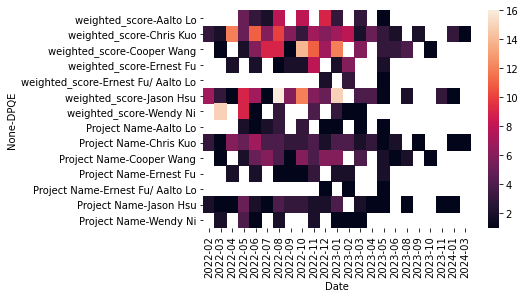

In [36]:
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).agg({'weighted_score':'sum', 'Project Name':'count'}).unstack(level=0).transpose())

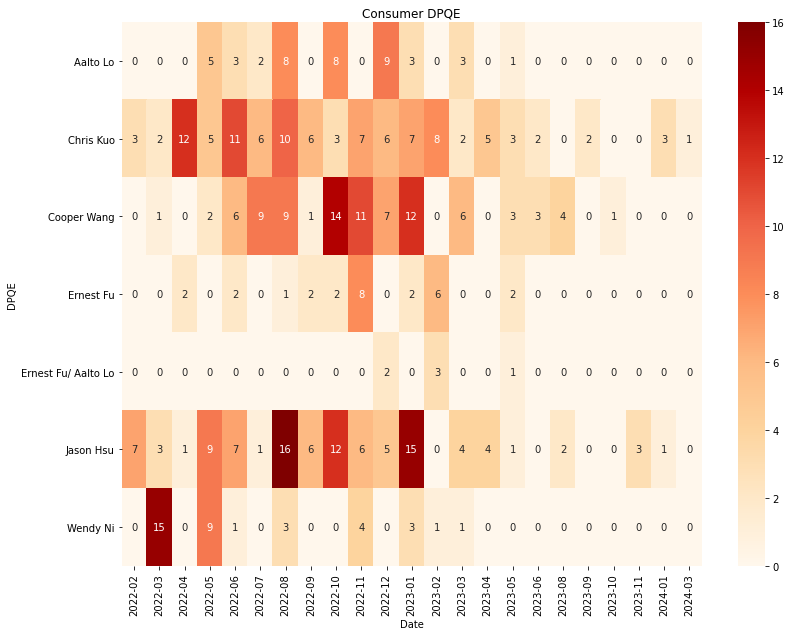

In [29]:
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).sum()['weighted_score'].unstack(fill_value=0),cmap="OrRd", annot=True).set(title='Consumer DPQE');
#plt.savefig('Consumer DPQE',bbox_inches = "tight")

In [31]:
df_consumer_dpqe_project = df_consumer_dpqe.groupby(['DPQE','Date','Project Name']).sum().sort_index()

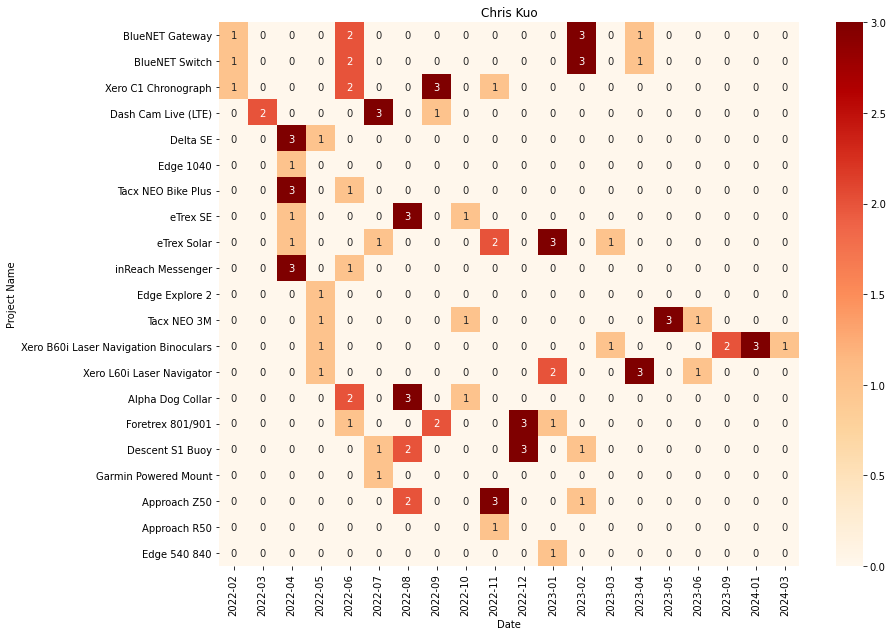

In [32]:
dpqe = 'Chris Kuo'
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Chris Kuo',bbox_inches = "tight")

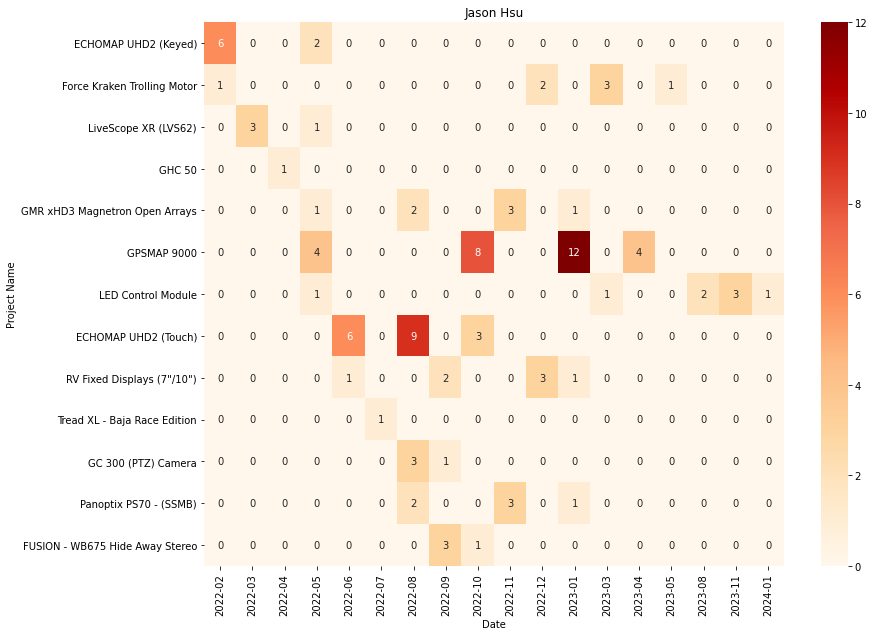

In [33]:
dpqe = 'Jason Hsu'
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Jason Hsu',bbox_inches = "tight")

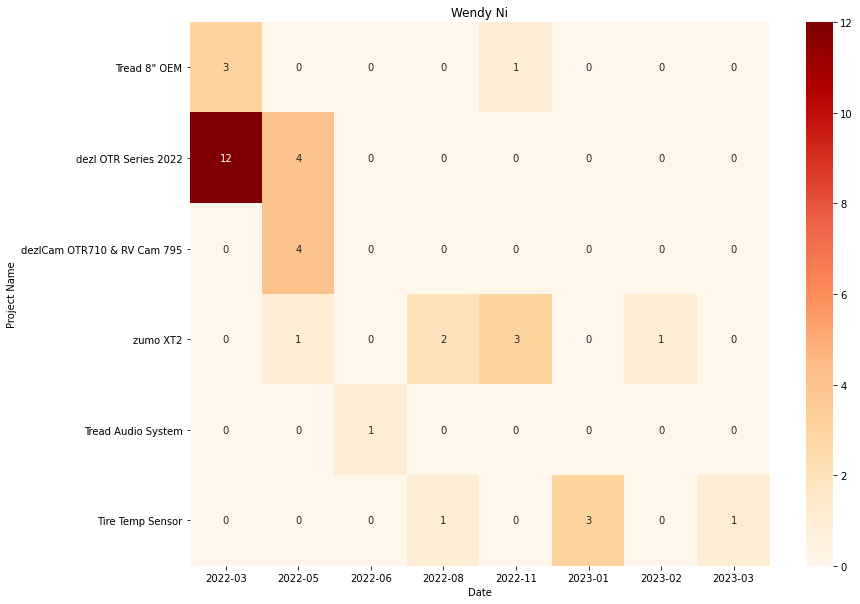

In [34]:
dpqe = 'Wendy Ni'
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Wendy Ni',bbox_inches = "tight")

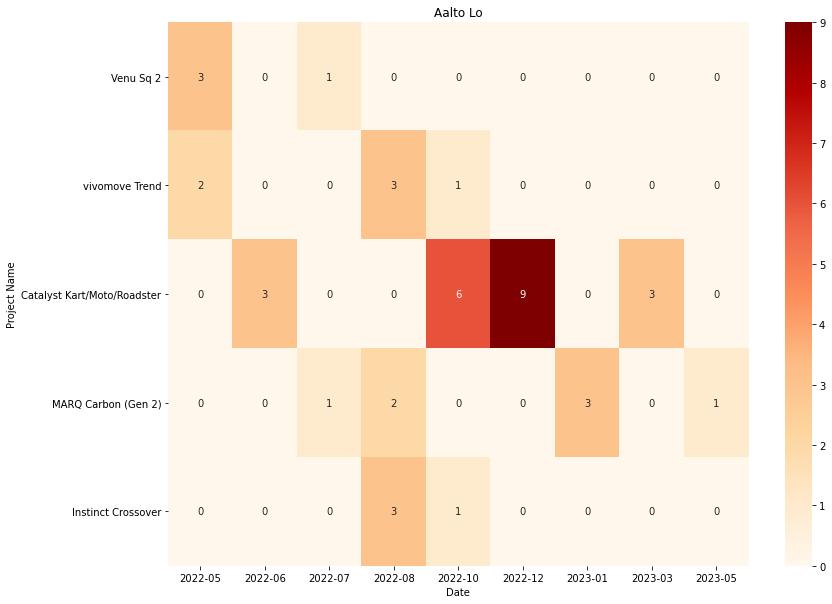

In [35]:
dpqe = 'Aalto Lo'
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Aalto Lo',bbox_inches = "tight")

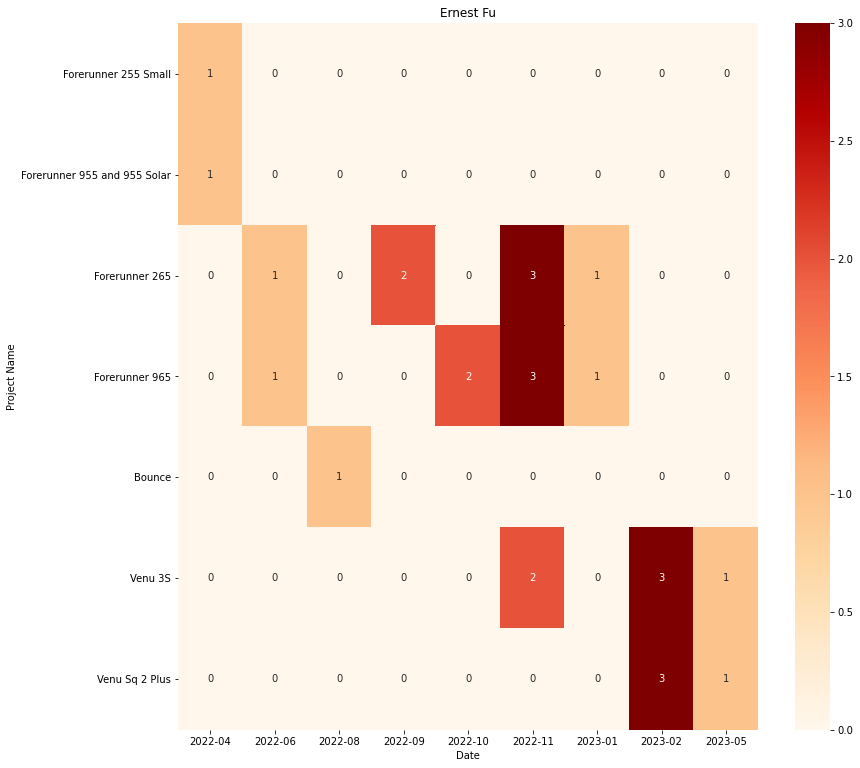

In [36]:
dpqe = 'Ernest Fu'
plt.figure(figsize=(13,13))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Ernest Fu',bbox_inches = "tight")

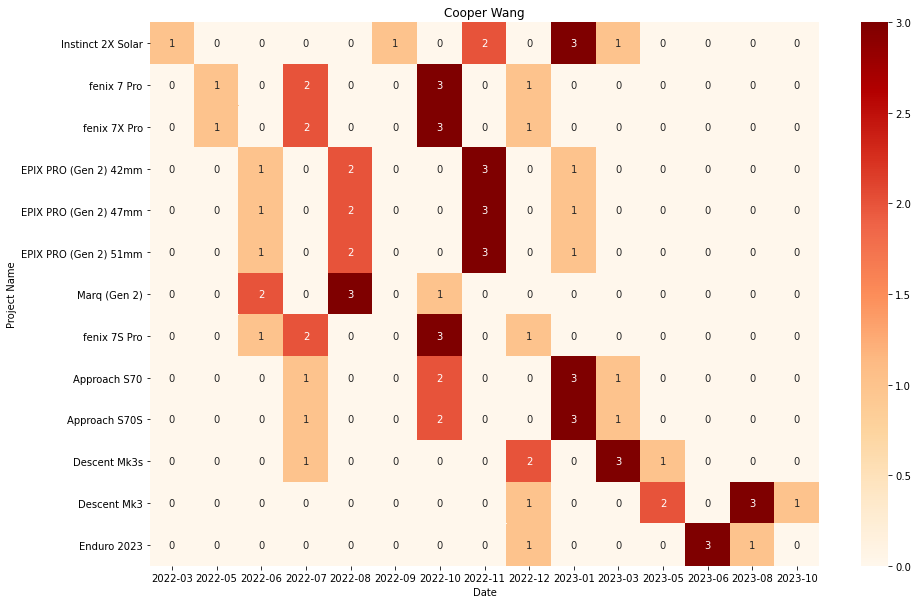

In [37]:
dpqe = 'Cooper Wang'
plt.figure(figsize=(15,10))
sns.heatmap(df_consumer_dpqe_project.loc[dpqe]['weighted_score'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=dpqe);
#plt.savefig('Cooper Wang',bbox_inches = "tight")

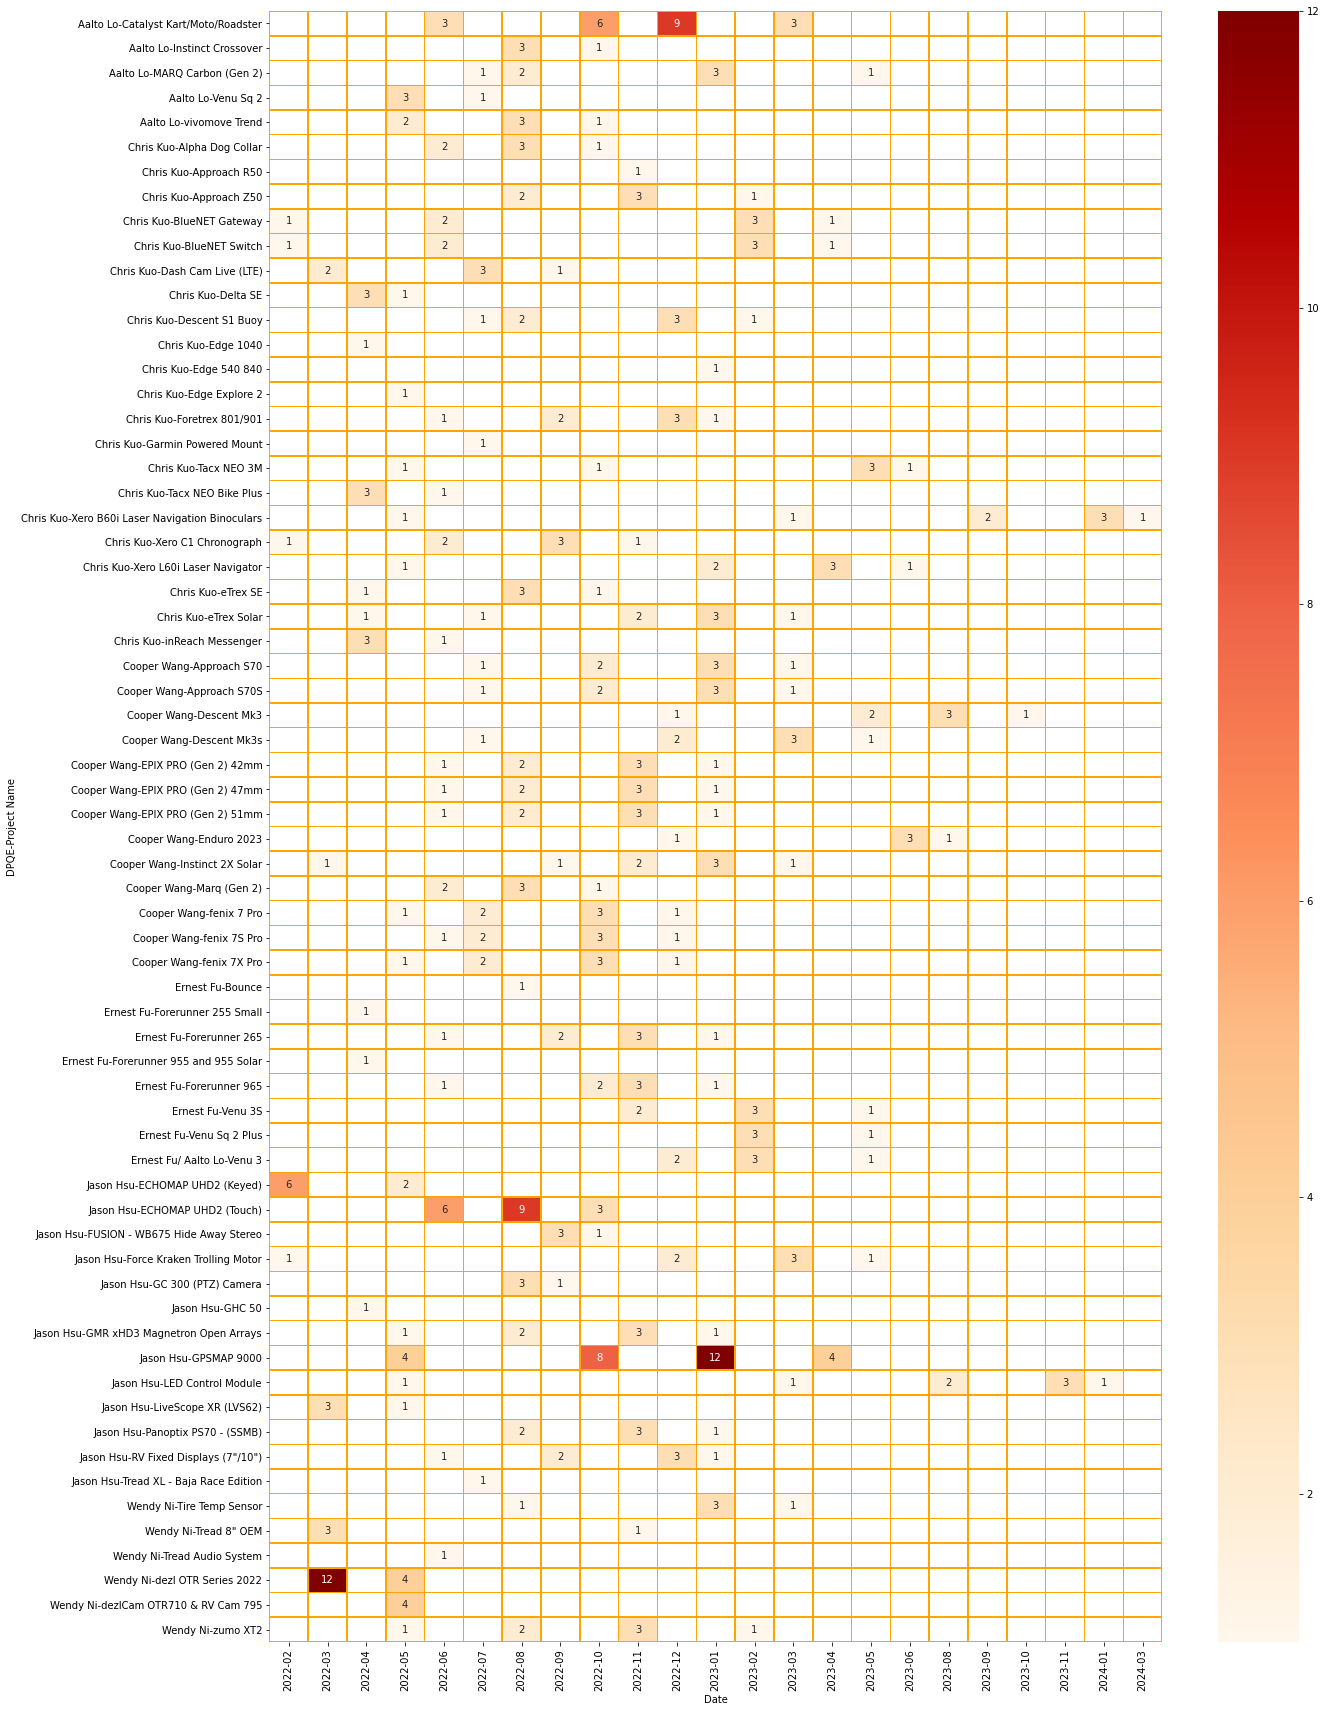

In [78]:
plt.figure(figsize=(20,30))
sns.heatmap(df_consumer_dpqe_project.unstack(level=1)['weighted_score'],cmap="OrRd", annot=True,linewidths=0.5, linecolor='orange');

In [80]:
df_consumer_dpqe_project.unstack(level=1)['weighted_score'].to_excel('overall.xlsx')

: 